In [1]:
%matplotlib inline
from os import listdir
from os.path import isfile, join
import numpy as np
from glob import glob
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib
import statsmodels.stats.multitest as smt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from adjustText import adjust_text
from scipy import stats
import itertools

In [2]:
## Read window-based pi, Tajima's D, and Fst 
dir_path = '/Users/osipova/Documents/LabDocs/Brood_parasites_analysis/'

db = 'indInd'
file_name_pi = 'PopGen_{}/passed.{}_full_final.10k.windowed.pi'.format(db, db)
file_name_D = 'PopGen_{}/passed.{}_full_final.10k.Tajima.D'.format(db, db)
file_name_fst = 'PopGen_{}/tree_vs_ground_Fst_10kb.windowed.weir.fst'.format(db)

# db = 'vidMac'
# file_name_pi = 'PopGen_{}/passed.{}_full_final.noAF_1.10k.windowed.pi'.format(db, db)
# file_name_D = 'PopGen_{}/passed.{}_full_final.noAF_1.10k.Tajima.D'.format(db, db)

# db = 'vidCha'
# file_name_pi = 'PopGen_{}/passed.{}_camerunensis.noAF_1.10k.windowed.pi'.format(db, db)
# file_name_D = 'PopGen_{}/passed.{}_camerunensis.noAF_1.10k.Tajima.D'.format(db, db)

file_data_pi = glob(dir_path + file_name_pi)[0]
file_data_D = glob(dir_path + file_name_D)[0]
file_data_fst = glob(dir_path + file_name_fst)[0]

df_pi = pd.read_csv(file_data_pi, sep='\t')
df_D = pd.read_csv(file_data_D, sep='\t')
df_fst = pd.read_csv(file_data_fst, sep='\t')

df_pi.head()

,CHROM,SCAFFOLD,BIN_START,BIN_END,N_VARIANTS,PI
0,chr1,CM051081,1,10000,23,0.000247
1,chr1,CM051081,20001,30000,20,0.000235
2,chr1,CM051081,30001,40000,165,0.002763
3,chr1,CM051081,40001,50000,190,0.003545
4,chr1,CM051081,50001,60000,155,0.002876


In [3]:
def make_position(dfi, col_chr, col_start):
    ## sorts by chromosome number and adds absolute postion column
    
    dfi = dfi.dropna()
    exclude = ['chrZ', 'chrW', 'chrNA', 'chrMT']
    dfi['COUNT'] = dfi[col_chr].str.replace('chr', '')
    
    dfi_num = dfi[ ~dfi[col_chr].isin(exclude)]
    dfi_Z = dfi[dfi[col_chr] == 'chrZ']
    dfi_W = dfi[dfi[col_chr] == 'chrW']
    
    dfi_num['COUNT'] = pd.to_numeric(dfi_num['COUNT'])
    dfi_num = dfi_num.sort_values(by=['COUNT', col_start])
    
    dfi_merged = pd.concat([dfi_num, dfi_Z, dfi_W], ignore_index=True)
    dfi_merged['POSITION'] = [x / 1000 for x in range(dfi_merged.shape[0])]
    return dfi_merged

In [14]:
df_pi_sorted = make_position(df_pi, 'CHROM', 'BIN_START')
df_D_sorted = make_position(df_D, 'CHROM', 'BIN_START')
df_fst_sorted = make_position(df_fst, 'CHROM', 'BIN_START')

## Merge Fst and TajimaD to find overlap
df_merged = pd.merge(df_fst_sorted, df_D_sorted[['TajimaD', 'POSITION']], on='POSITION')

/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


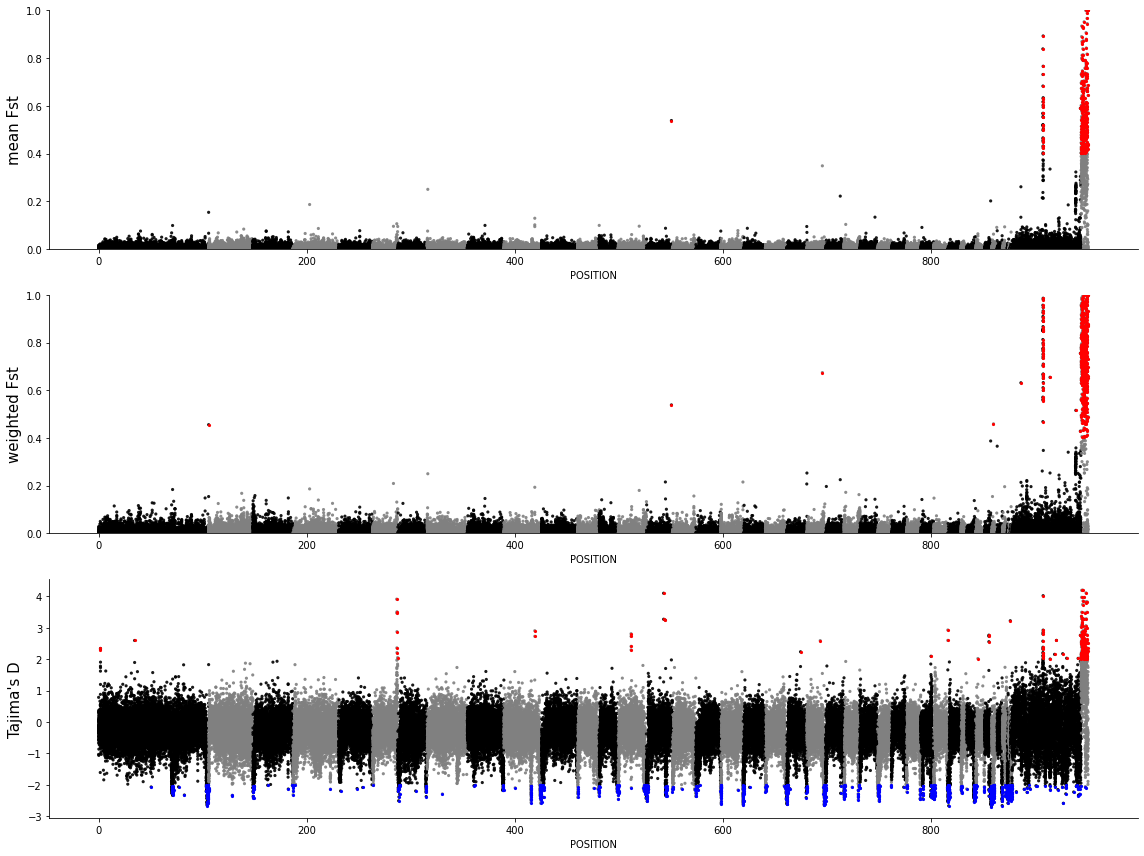

In [29]:
## Plot by window position sccross the whole genome
exclude = ['chrZ', 'chrW', 'chrNA']

## get Tajima's D extremes
high_D = df_D_sorted[df_D_sorted['TajimaD'] > 2]
low_D = df_D_sorted[df_D_sorted['TajimaD'] < -2]

## get Fst extremes
high_fst_weighted = df_fst_sorted[df_fst_sorted['WEIGHTED_FST'] > 0.4]
high_fst_mean = df_fst_sorted[df_fst_sorted['MEAN_FST'] > 0.4]

fig, axes = plt.subplots(3, 1, figsize=(16, 4*3))
ax1, ax2, ax3 = axes[0], axes[1], axes[2]

N = len(set(df_pi_sorted['COUNT']))
p = (['black', 'grey'] * (int(N / 2) + 1))[:N]

# ## pi
# sns.scatterplot(ax=ax1, data=df_pi_sorted, x='POSITION', y='PI', hue='CHROM', 
#                 s=10, linewidth=0, alpha=0.9, palette=p)
sns.scatterplot(ax=ax1, data=df_fst_sorted, x='POSITION', y='MEAN_FST', hue='CHROM', 
                s=10, linewidth=0, alpha=0.9, palette=p)
sns.scatterplot(ax=ax1, data=high_fst_mean, x='POSITION', y='MEAN_FST', s=10, linewidth=0, color='red')


## Tajima's D
sns.scatterplot(ax=ax3, data=df_D_sorted, x='POSITION', y='TajimaD', hue='CHROM', 
                s=10, linewidth=0, alpha=0.9, palette=p)
sns.scatterplot(ax=ax3, data=high_D, x='POSITION', y='TajimaD', s=10, linewidth=0, color='red')
sns.scatterplot(ax=ax3, data=low_D, x='POSITION', y='TajimaD', s=10, linewidth=0, colo=1r='blue')
# Fst
sns.scatterplot(ax=ax2, data=df_fst_sorted, x='POSITION', y='WEIGHTED_FST', hue='CHROM', 
                s=10, linewidth=0, alpha=0.9, palette=p)
sns.scatterplot(ax=ax2, data=high_fst_weighted, x='POSITION', y='WEIGHTED_FST', s=10, linewidth=0, color='red')
# ## Fst no chrZ, chrW
# sns.scatterplot(ax=ax4, data=df_fst_sorted[ ~df_fst_sorted['CHROM'].isin(exclude)],
#                 x='POSITION', y='WEIGHTED_FST', hue='CHROM', 
#                 s=10, linewidth=0, alpha=0.9, palette=p[:-2])
ax2.set(ylim = (0, 1))
ax1.set(ylim = (0, 1))
# ax1.set_ylabel('pi', size = 15)
ax1.set_ylabel('mean Fst', size = 15)
ax3.set_ylabel('Tajima\'s D', size = 15)
ax2.set_ylabel('weighted Fst', size = 15)


sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
for axi in [ax1, ax2, ax3]:
    axi.legend([], [], frameon=False)

fig.tight_layout()

pdf_name = 'Fst_mean_weight_TajimaD.{}.by_chromosome.pdf'.format(db)
# fig.savefig(pdf_name, bbox_inches='tight')

In [80]:
## Check regions of high Fst or TajimaD
df_high = df_merged[df_merged['TajimaD'] > 2]
df_high = df_high[~ df_high['CHROM'].isin(exclude)][['SCAFFOLD', 'BIN_START', 'BIN_END']]
df_high['START'] = df_high['BIN_START'] - 20000
df_high['END'] = df_high['BIN_END'] + 20000
df_high[['SCAFFOLD', 'START', 'END']]

,SCAFFOLD,START,END
184,CM051081,1830001,1880000
186,CM051081,1850001,1900000
3468,CM051081,46130001,46180000
28664,CM051086,43440001,43490000
28665,CM051086,43450001,43500000
28680,CM051086,43600001,43650000
28691,CM051086,43710001,43760000
28693,CM051086,43730001,43780000
28694,CM051086,43740001,43790000
28755,CM051086,44350001,44400000


In [192]:
## Zoom in on regions of high Fst or high TajimaD
db = 'indInd'
file_name_D = 'PopGen_{}/high_TajimaD.passed.{}_full_final.sliding.D'.format(db, db)
file_name_fst = 'PopGen_{}/tree_vs_ground_Fst_1kb.windowed.weir.fst'.format(db)

file_data_D = glob(dir_path + file_name_D)[0]
file_data_fst = glob(dir_path + file_name_fst)[0]

df_D = pd.read_csv(file_data_D, sep='\t')
df_fst = pd.read_csv(file_data_fst, sep='\t')

df_D['START'] = df_D['BIN_START'] / 10**6

df_fst['START'] = df_fst['BIN_START'] / 10**6
df_fst['END'] = df_fst['BIN_END'] / 10**6

In [4]:
def separate_intervals(L, step):
    
    n = 0
    L_enum = [str(n)]
    el = L[0]
    for i in range(len(L) - 1):
        if L[i+1] - el < 4 * step:
            L_enum.append(str(n))
        else:
            n += 1
            L_enum.append(str(n))
        el = L[i+1]
    return L_enum

In [193]:
L_enum = separate_intervals(list(df_D['BIN_START']), step=1000)
df_D['interval'] = df_D['CHROM'] + '.' + L_enum

In [168]:
## Run if you want to zoom in at specific intervals
selected_int = ['chr10.13', 'chr14.17', 'chr6.7', 'chr6.8']
df_D = df_D[df_D['interval'].isin(selected_int)]

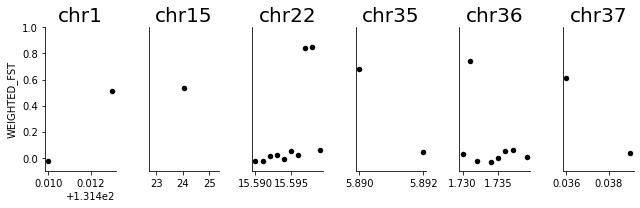

In [136]:
## Plot Fst sliding window 1kb
chroms = sorted(list(set(df_fst['CHROM'])))

fig, axes = plt.subplots(1, len(chroms), figsize=(9, 3))
for i in range(len(chroms)):
    chri = chroms[i]
    axi = axes[i]

    dfi = df_fst[df_fst['CHROM'] == chri]
    sns.scatterplot(ax=axi, data=dfi, x='START', y='WEIGHTED_FST', s=30, linewidth=0, color='k')
    axi.set(ylim=(-0.1, 1))
    axi.set_title(chri, fontsize=20)
    axi.set_xlabel('')
    if i != 0:
        axi.set_ylabel('')
        axi.set(yticklabels=[])
        axi.tick_params(left=False)
    sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
    fig.tight_layout()
    
pdf_name = 'high_Fst.1kb.{}.pdf'.format(db)
# fig.savefig(pdf_name, bbox_inches='tight')

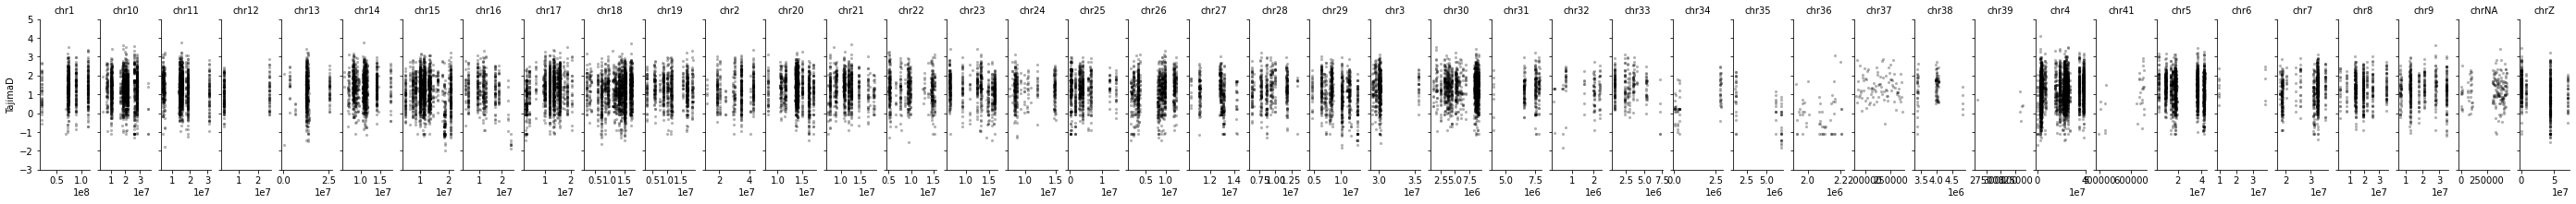

In [194]:
## Plot TajimaD sliding window 1kb
chroms = sorted(list(set(df_D['CHROM'])))

fig, axes = plt.subplots(1, len(chroms), figsize=(49, 3))
for i in range(len(chroms)):
    chri = chroms[i]
    axi = axes[i]

    dfi = df_D[df_D['CHROM'] == chri]
    sns.scatterplot(ax=axi, data=dfi, x='BIN_START', y='TajimaD', s=10, alpha=0.3, linewidth=0, color='k')
    axi.set(ylim=(-3, 5))
    axi.set_title(chri, fontsize=10)
    axi.set_xlabel('')
    if i != 0:
        axi.set_ylabel('')
        axi.set(yticklabels=[])
#         axi.tick_params(left=False)
    sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
#     fig.tight_layout()
    
# pdf_name = 'selected_chr.high_TajimaD.100bp.intervals.{}.pdf'.format(db)
# fig.savefig(pdf_name, bbox_inches='tight')

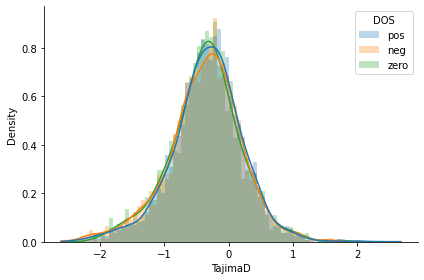

In [12]:
## Check TajimaD distributions for DoS < 0 and DoS > 0
db = 'indInd'
file_name_D = 'PopGen_{}/all_dos.passed.{}.10k.Tajima.D'.format(db, db)
file_data_D = glob(dir_path + file_name_D)[0]
df_D = pd.read_csv(file_data_D, sep='\t')
df_D = df_D.dropna()

fig, axes = plt.subplots(figsize=(6, 4))
sns.histplot(df_D[df_D['DOS'] != 'ra_na'], x='TajimaD', hue='DOS', alpha=0.3,
             linewidth=0, stat="density", kde=True, common_norm=False)

sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

In [ ]:
## blank

/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

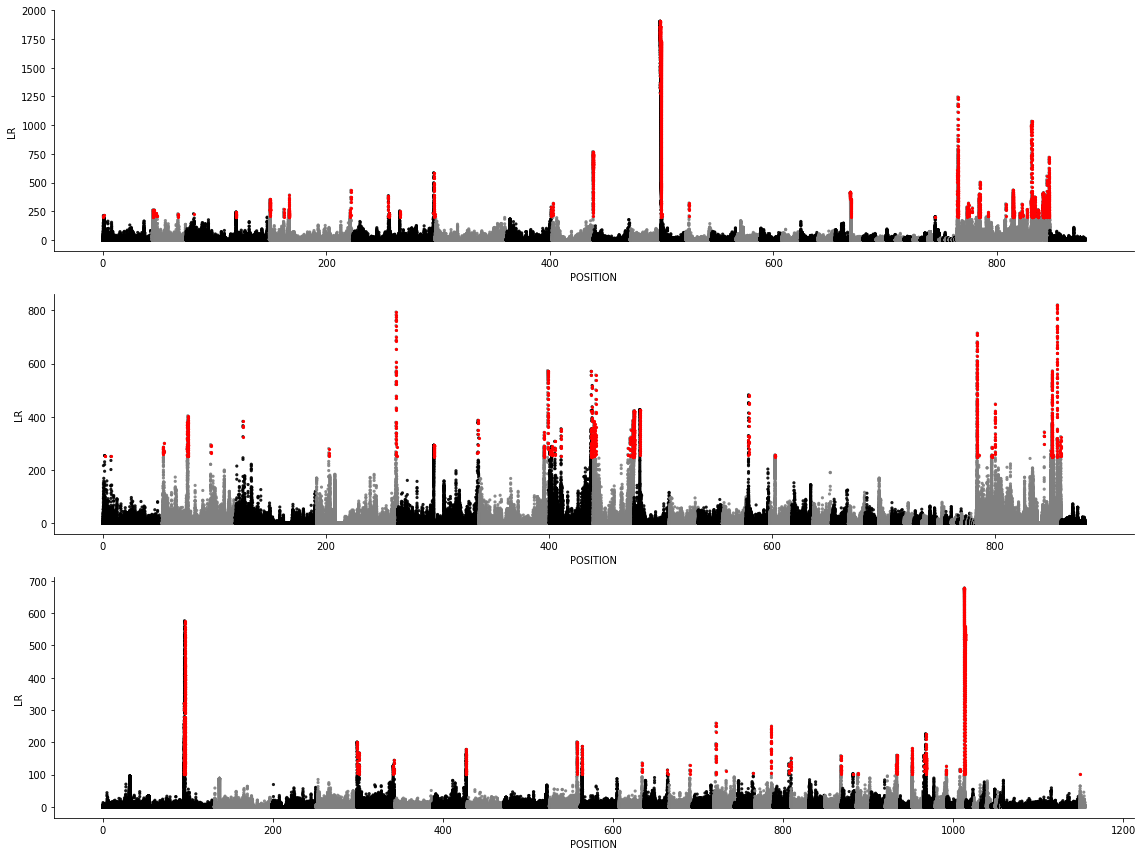

In [6]:
## SweepFinder2
dir_path = '/Users/osipova/Documents/LabDocs/Brood_parasites_analysis/'
dbs = ['vidMac', 'vidCha', 'indInd']
limits = [200, 250, 100]
fig, axes = plt.subplots(3, 1, figsize=(16, 4*3))

for i in range(len(dbs)):
    db = dbs[i]
    axi = axes[i]
    
    file_name_SF = 'PopGen_{}/all_chroms.sweepfinder2.out'.format(db)
    file_data_SF = glob(dir_path + file_name_SF)[0]
    df_SF = pd.read_csv(file_data_SF, sep='\t')
    df_SF_sorted = make_position(df_SF, 'chr', 'location')

    N = len(set(df_SF_sorted['COUNT']))
    p = (['black', 'grey'] * (int(N / 2) + 1))[:N]

    ## SweepFinder2: LR
    df_sign = df_SF_sorted[(df_SF_sorted['alpha'] < .01) & (df_SF_sorted['LR'] > limits[i])]
    sns.scatterplot(ax=axi, data=df_SF_sorted, x='POSITION', y='LR', hue='chr', 
                    s=10, linewidth=0, alpha=0.9, palette=p)
    sns.scatterplot(ax=axi, data=df_sign, x='POSITION', y='LR',
                    s=10, linewidth=0, color='red')

    sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
    axi.legend([], [], frameon=False)

fig.tight_layout()

pdf_name = 'sweepFinder2.3_clades.by_chromosome.pdf'
# fig.savefig(pdf_name, bbox_inches='tight')


/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/osipova/local/Homebrew/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


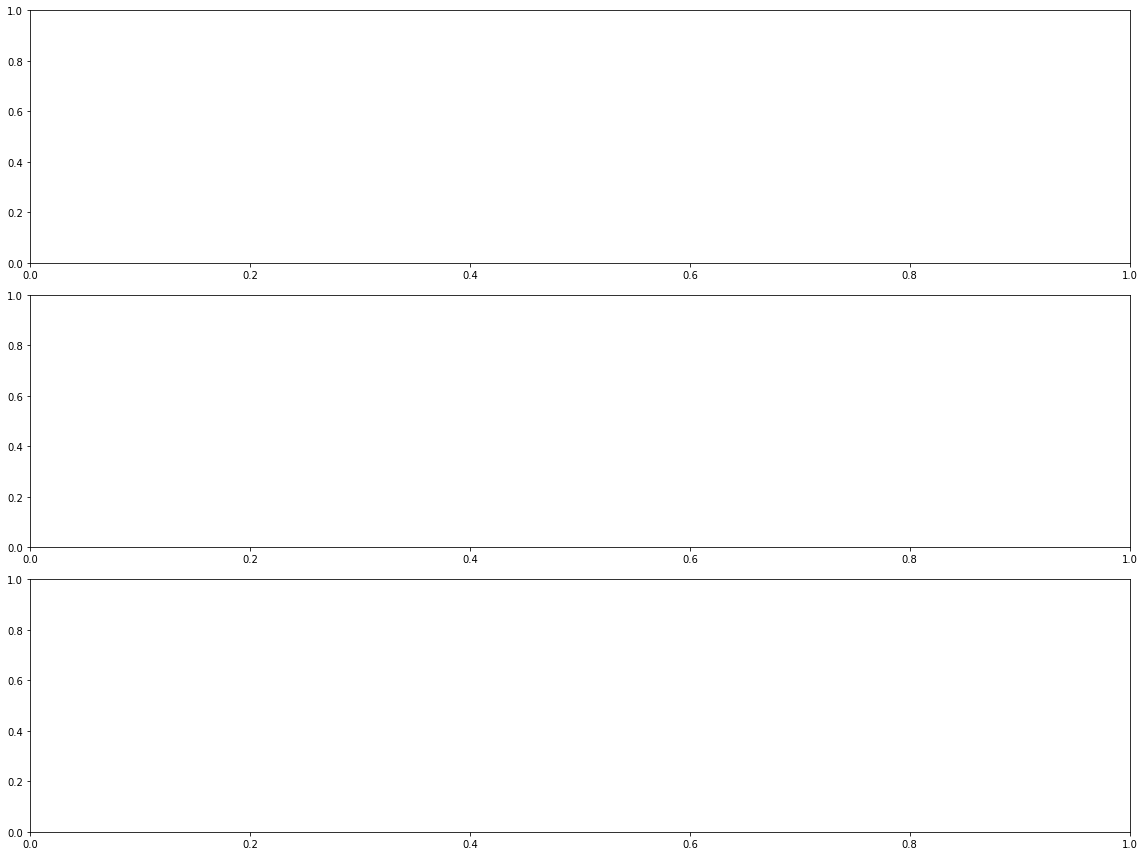

In [60]:
## Plot intervals of high LR
dbs = ['vidMac', 'vidCha', 'indInd']
limits = [200, 250, 100]
all_coords_dict = {}

fig, axes = plt.subplots(3, 1, figsize=(16, 4*3))

for i in range(len(dbs)):
    db = dbs[i]
    axi = axes[i]
    
    file_name_SF = 'PopGen_{}/all_chroms.sweepfinder2.out'.format(db)
    file_data_SF = glob(dir_path + file_name_SF)[0]
    df_SF = pd.read_csv(file_data_SF, sep='\t')
    df_SF_sorted = make_position(df_SF, 'chr', 'location')
    
    
    df_SF_high = df_SF_sorted[df_SF_sorted['LR'] > limits[i]]
    df_SF_high.rename(columns={'POSITION':'x'}, inplace=True)
    df_SF_high_sorted = make_position(df_SF_high, 'chr', 'location')
    
 
    N = len(set(df_SF_high_sorted['COUNT']))
    p = (['black', 'grey'] * (int(N / 2) + 1))[:N]

    ## SweepFinder2: LR
#     sns.scatterplot(ax=axi, data=df_SF_high_sorted, x='POSITION', y='LR', hue='chr', 
#                     s=10, linewidth=0, alpha=0.9, palette=p)

    ## separate intervals of high LR for plotting
    L_enum = separate_intervals(list(df_SF_high_sorted['location']), step=1000)
    df_SF_high_sorted['interval'] = df_SF_high_sorted['COUNT'].astype(str) + '.' + L_enum
    temp_df = df_SF_high_sorted.groupby(['interval', 'scaffold'],
                                        as_index=False).agg({'location': ['min', 'max']})
    temp_df['start'] = temp_df[('location', 'min')] - 100000
    temp_df['end'] = temp_df[('location', 'max')] + 100000
    temp_df[['scaffold', 'start', 'end']].set_index('scaffold').to_csv('high_SF2.{}.bed'.format(db), sep='\t')
    
    ## Make scaffold-based dictionary to store ALL coordinates of intervals of high SF
    step = 1000
    coords_list = []
    for j in range(len(temp_df['start'])):
        start = round(int(temp_df['start'][j]) / 1000) * 1000
        end = round(int(temp_df['end'][j]) / 1000) * 1000
        scaffold = temp_df['scaffold'][j]
        coords_list.extend([scaffold + '.' + str(c) for c in range(start, end-10000, step)])
    all_coords_dict[db] = coords_list
    
#     temp_df = df_SF_high_sorted
#     ends = list(temp_df.groupby('COUNT')['POSITION'].max())
    
#     starts_loc = list(temp_df.groupby('COUNT')['location'].min())
#     ends_loc = list(temp_df.groupby('COUNT')['location'].max())
    
#     ends_lables = pd.to_numeric(round(temp_df[temp_df['POSITION'].isin(ends)]['x']), downcast='integer')
#     axi.set_xticks(ends)
#     axi.set_xticklabels(list(ends_lables) , rotation=45, ha='right')
#     for l in ends:
#         axi.axvline(l, color='k', linewidth=0.25)

#     sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
#     axi.legend([], [], frameon=False)

fig.tight_layout()

pdf_name = 'zoom_high_LR.sweepFinder2.3clades.by_chromosome.pdf'
# fig.savefig(pdf_name, bbox_inches='tight')

/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


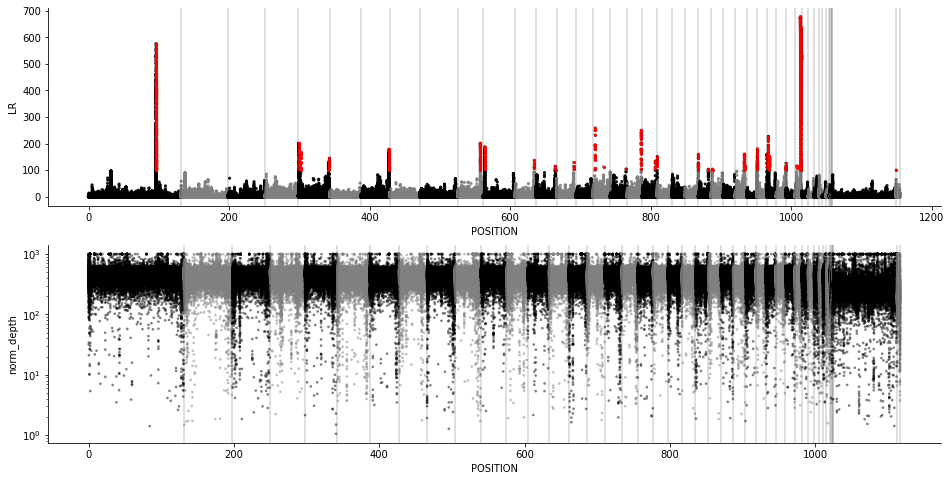

In [101]:
## SweepFinder2
dir_path = '/Users/osipova/Documents/LabDocs/Brood_parasites_analysis/'
limits = [200, 250, 100]
fig, axes = plt.subplots(2, 1, figsize=(16, 4*2))
ax1, ax2 = axes[0], axes[1]

db = 'indInd'

file_name_SF = 'PopGen_{}/all_chroms.sweepfinder2.out'.format(db)
file_data_SF = glob(dir_path + file_name_SF)[0]
df_SF = pd.read_csv(file_data_SF, sep='\t')
df_SF_sorted = make_position(df_SF, 'chr', 'location')


file_name_depth = 'PopGen_{}/all_depth.1kb.tsv'.format(db)
file_data_depth = glob(dir_path + file_name_depth)[0]
df_depth = pd.read_csv(file_data_depth, sep='\t')
df_depth['norm_depth'] = [d if d<1000 else 1000 for d in df_depth['depth']]
df_depth_sorted = make_position(df_depth, 'chr', 'start')

N = len(set(df_SF_sorted['COUNT']))
p = (['black', 'grey'] * (int(N / 2) + 1))[:N]

## SweepFinder2: LR
df_sign = df_SF_sorted[(df_SF_sorted['alpha'] < .01) & (df_SF_sorted['LR'] > limits[i])]
sns.scatterplot(ax=ax1, data=df_SF_sorted, x='POSITION', y='LR', hue='chr', 
                s=10, linewidth=0, alpha=0.9, palette=p)
sns.scatterplot(ax=ax1, data=df_sign, x='POSITION', y='LR',
                s=10, linewidth=0, color='red')

sns.scatterplot(ax=ax2, data=df_depth_sorted, x='POSITION', y='norm_depth', hue='chr', 
                s=7, linewidth=0, alpha=0.5, palette=p)

temp_df = df_SF_sorted
ends = list(temp_df.groupby('chr')['POSITION'].max())
for l in ends:
    ax1.axvline(l, color='k', linewidth=0.25)


temp_df = df_depth_sorted
ends = list(temp_df.groupby('chr')['POSITION'].max())
for l in ends:
    ax2.axvline(l, color='k', linewidth=0.25)
    
ax1.legend([], [], frameon=False)
ax2.legend([], [], frameon=False)
ax2.set(yscale="log")
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)


In [65]:
def read_and_sort_chr_tsv(dir_path, file_name, chrom, position):
    ## Reads a csv file, assumes format: chrom \t position \t some data
    
    file_data = glob(dir_path + file_name)[0]
    df = pd.read_csv(file_data, sep='\t')
    df.rename(columns = {'CHROM':'chr',
                         'BIN_START':'location',
                         'start':'location' },
                          inplace=True, errors='ignore')
    
    df_sorted = make_position(df, chrom, position)
    df_sorted['norm_loc'] = [round(i/1000)*1000 for i in df_sorted['location']]
    return df_sorted

In [77]:
def merge_SF_depth_pi(df_SF, df_depth, df_pi, df_TD, all_coords):
    ## Merges SweepFinder2, depth, PI, and TajimaD dataframes
    
    df_SF['coord'] = df_SF['scaffold'] + '.' + df_SF['norm_loc'].astype(str)
    df_SF_intervals = df_SF[df_SF['coord'].isin(all_coords)]

    d_temp = pd.merge(df_SF_intervals, 
                      df_depth[['chr', 'norm_loc', 'norm_depth']],
                      on=['chr', 'norm_loc'],
                      how='left').fillna(min(df_depth['norm_depth']))

    d_merged = pd.merge(d_temp,
                        df_pi[['chr', 'norm_loc', 'PI']],
                        on=['chr', 'norm_loc'],
                        how='left').fillna(min(df_pi['PI']))
    
    d_merged = pd.merge(d_merged,
                        df_TD[['chr', 'norm_loc', 'TajimaD']],
                        on=['chr', 'norm_loc'],
                        how='left')
    return d_merged

In [78]:
## Load data
dir_path = '/Users/osipova/Documents/LabDocs/Brood_parasites_analysis/'
dbs = ['vidMac', 'vidCha', 'indInd']
all_dfs = {}

for db in dbs:
    print(db)
    ## Load SweepFinder2 results
    file_name_SF = 'PopGen_{}/all_chroms.sweepfinder2.out'.format(db)
    df_SF_sorted = read_and_sort_chr_tsv(dir_path, file_name_SF, 'chr', 'location')

    ## Load depth calculations 
    file_name_depth = 'PopGen_{}/all_depth.1kb.tsv'.format(db)
    df_depth_sorted = read_and_sort_chr_tsv(dir_path, file_name_depth, 'chr', 'location')
    df_depth_sorted['norm_depth'] = [d if d < 1000 else 1000 for d in df_depth_sorted['depth']]

    ## Load PI data for high LR regions with flanks
    file_name_pi = 'PopGen_{}/high_SF2.{}.slide.windowed.pi'.format(db, db)
    df_pi_sorted = read_and_sort_chr_tsv(dir_path, file_name_pi, 'chr', 'location')

    
    ## Load TajimaD data for high LR regions with flanks
    file_name_TD = 'PopGen_{}/high_SF2.{}.slide.TajimaD'.format(db, db)
    df_TD_sorted = read_and_sort_chr_tsv(dir_path, file_name_TD, 'chr', 'location')
    
    ## Store all in one dictionary for all dbs
    all_dfs[db] = {'SF': df_SF_sorted,
                   'depth': df_depth_sorted,
                   'PI': df_pi_sorted,
                   'TajimaD': df_TD_sorted}

vidMac


/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


vidCha
indInd


/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

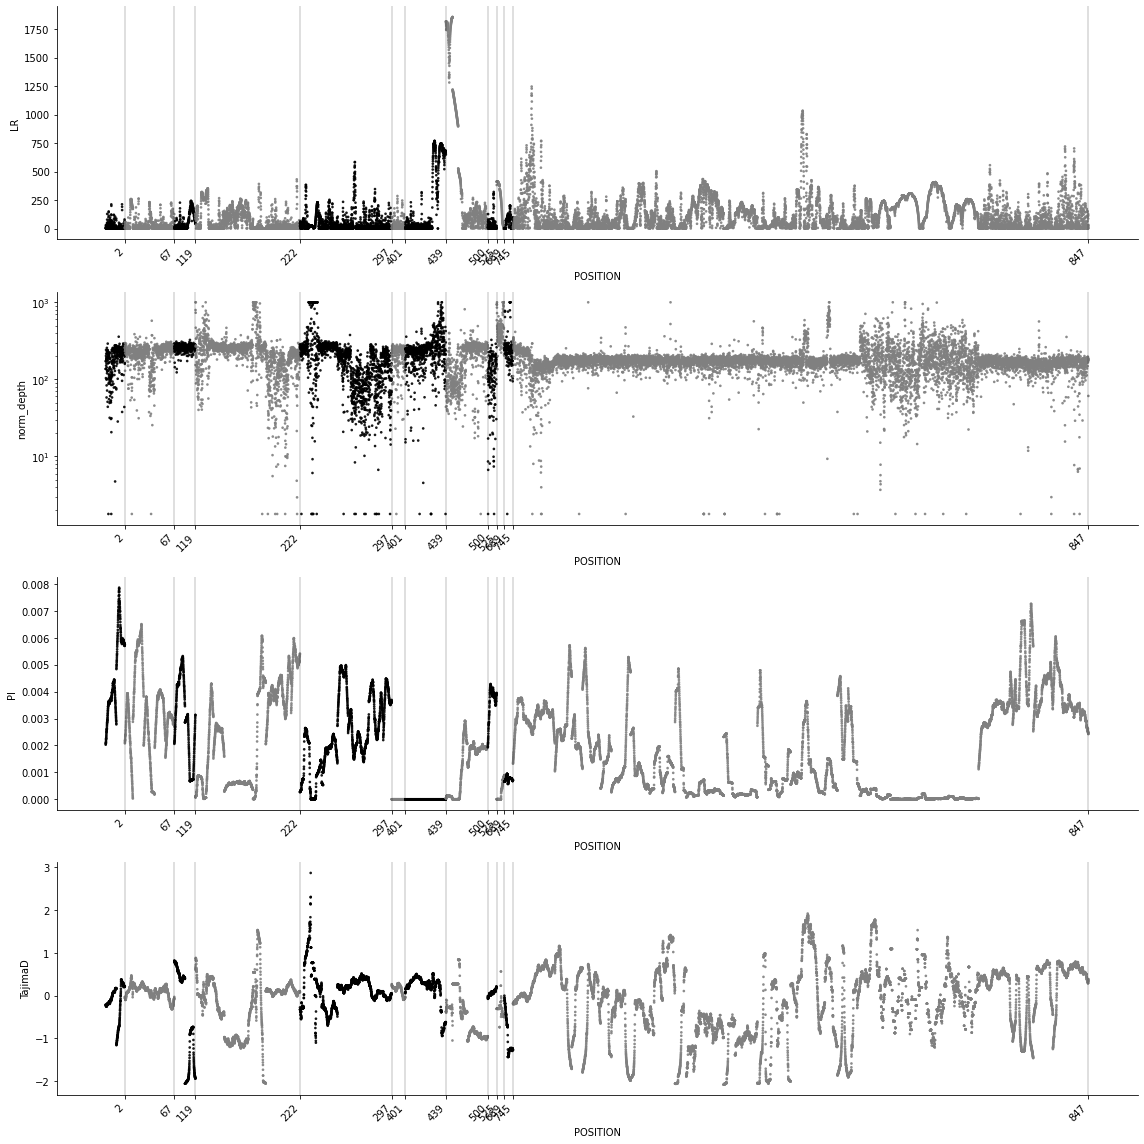

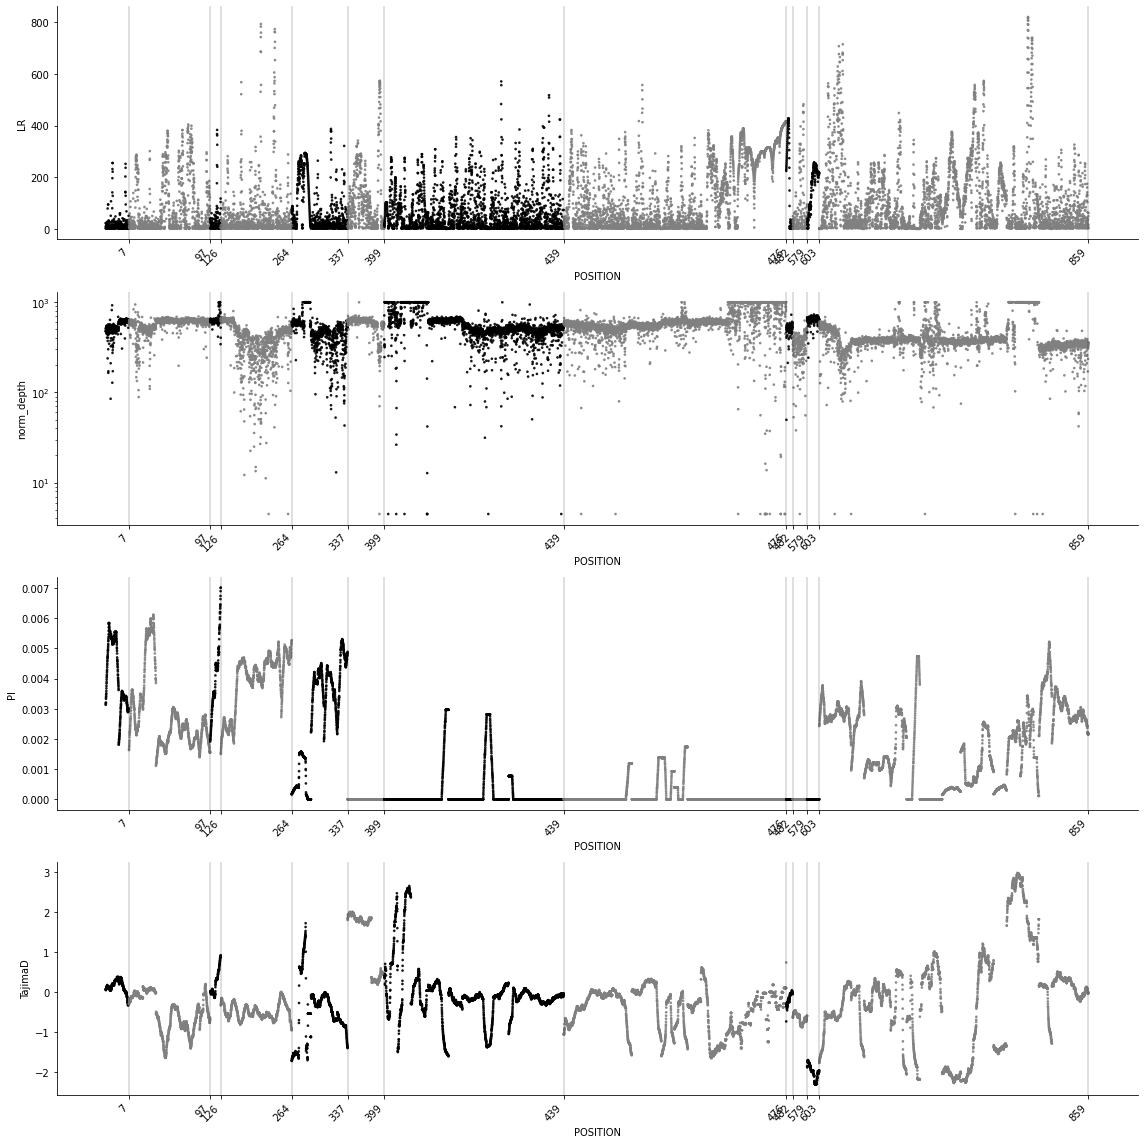

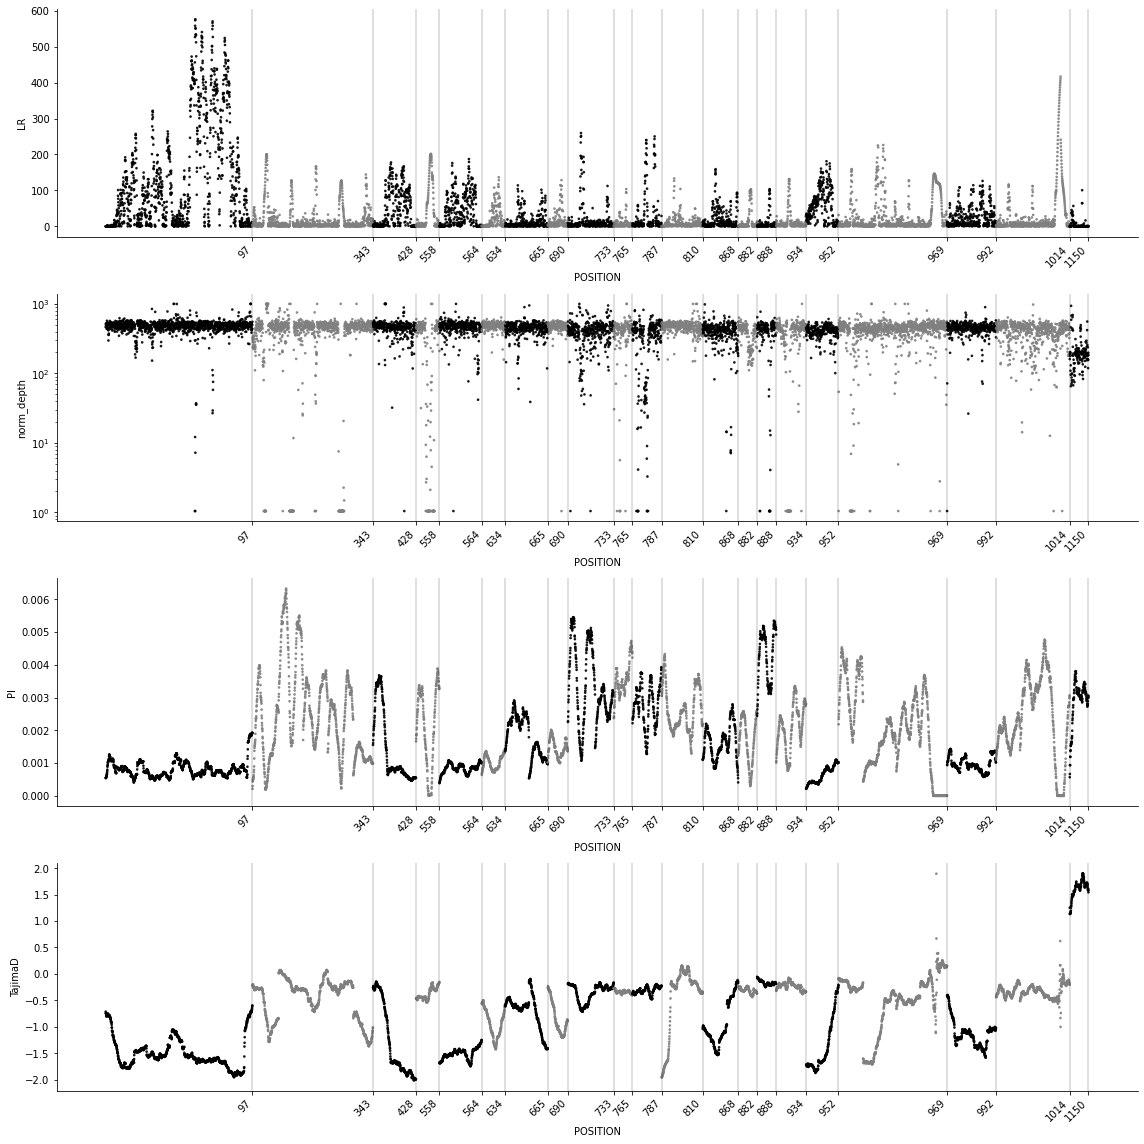

In [79]:
values_plot = [('SF','LR'), ('depth', 'norm_depth'), ('PI', 'PI'), ('TajimaD', 'TajimaD')]

for db in dbs:
    fig, axes = plt.subplots(4, 1, figsize=(16, 4*4))
    ax1, ax2, ax3, ax4 = axes[0], axes[1], axes[2], axes[3]

    d_merged = merge_SF_depth_pi(all_dfs[db]['SF'],
                                 all_dfs[db]['depth'],
                                 all_dfs[db]['PI'],
                                 all_dfs[db]['TajimaD'],
                                 all_coords_dict[db])

    d_merged.rename(columns={'POSITION':'x'}, inplace=True)
    d_merged_sorted = make_position(d_merged, 'chr', 'location')
    d_merged_sorted['logpi'] = np.log10(d_merged_sorted['PI'])
    
    N = len(set(d_merged_sorted['COUNT']))
    p = (['black', 'grey'] * (int(N / 2) + 1))[:N]
    
    ends = list(d_merged_sorted.groupby('COUNT')['POSITION'].max())
    ends_loc = list(d_merged_sorted.groupby('COUNT')['location'].max())
    ends_lables = pd.to_numeric(round(d_merged_sorted[d_merged_sorted['POSITION'].isin(ends)]['x']),
                                downcast='integer')
    for i in range(4):
        axi = axes[i]
        sns.scatterplot(ax=axi, data=d_merged_sorted, 
                        x='POSITION',
                        y=values_plot[i][1],
                        hue='chr', s=7, linewidth=0, alpha=0.9, palette=p)
        axi.set_xticks(ends)
        axi.set_xticklabels(list(ends_lables) , rotation=45, ha='right')
        axi.legend([], [], frameon=False)
        for l in ends:
            axi.axvline(l, color='k', linewidth=0.25)

    ax2.set(yscale="log")
    sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
    fig.tight_layout()

    pdf_name = 'zoom_in.LR_depth_slide_pi_TajimaD.{}.pdf'.format(db)
    fig.savefig(pdf_name)